In [50]:
import torch
import torchvision
from torch import nn
import numpy as np
import pandas as pd
import PIL
import os
from pathlib import Path
import matplotlib.pyplot as plt

In [51]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [52]:
!pip install efficientnet_pytorch

In [53]:
from efficientnet_pytorch import EfficientNet

In [54]:
# model = EfficientNet.from_name('efficientnet-b0')

In [55]:
MODEL = "/content/Med_Vision_model_v1_effnet_full_architecture_and_weights_4E.pth"

In [56]:
loaded_model = torch.load(MODEL)

<ipython-input-56-7b70ae2b237a>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model = torch.load(MODEL)


In [57]:
class_names = ['Acne_(Normal_to_Mild)',
  'Conjunctivitis',
  'Folliculitis',
  'Nail Fungus and other Nail Disease',
  'Stye (Inflammation around eyes)',
  'Tinea Ringworm Candidiasis and other Fungal Infections',
  'Urticaria Hives',
  'Warts Molluscum with Viral Infections']

###Making Predictions using the model

Defining a function to take a model, image path, class names, image size to be used, transform, and device (to put it to GPU)

In [67]:
from typing import List, Tuple
from PIL import Image
from torchvision import transforms

def Show_Predcitions(model: torch.nn.Module,
                     uploaded_image_path: str,
                     class_names: List[str],
                     image_size: Tuple[int, int] = (256,256),
                     transform: torchvision.transforms = None):
  img = Image.open(uploaded_image_path)

  #transforming the image as per the requirements
  if transform is not None:
    image_transform = transforms
  else:
    image_transforms = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

    model.eval()

    # model = model.to(device)
    with torch.inference_mode():
      transformed_image = image_transforms(img).unsqueeze(axis=0) #adding ectra batch dimension

      #making a prediction
      target_image_pred = model(transformed_image) #this will output raw logits

    #Using softmax to convert them into prediction probabilities
    target_image_pred_prob = torch.softmax(target_image_pred, dim=1)

    #Using argmax to find the class/label from the predicted probability
    target_image_pred_label = torch.argmax(target_image_pred_prob, dim=1)

    plt.figure()
    plt.imshow(img)
    plt.title(
        f"Pred: {class_names[target_image_pred_label]} | "
        f"Probability: {int(target_image_pred_prob.max()*100)}%"
        # if target_image_pred_prob.max() > 0.3
        # else f"Pred: CANNOT DETERMINE | Probability: {int(target_image_pred_prob.max()*100)}%"
    )
    plt.axis(False)

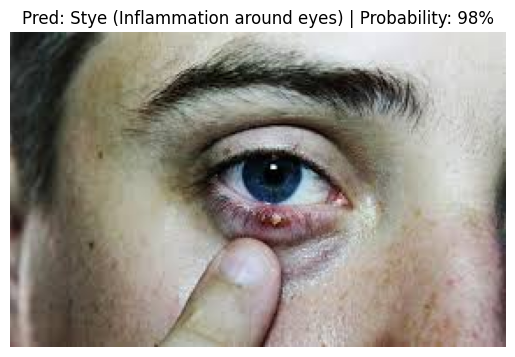

In [68]:
path = "/content/images.jpg"
Show_Predcitions(model=loaded_model.cpu(),
                 uploaded_image_path=path,
                 class_names=class_names,
                 image_size=(256,256),
                 )

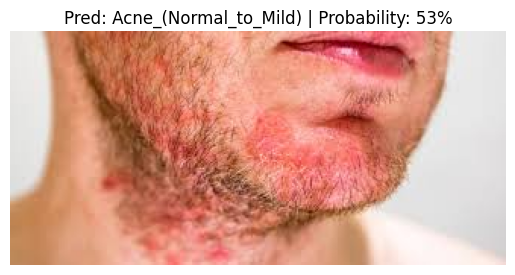

In [69]:
path = "/content/2.jpg"
Show_Predcitions(model=loaded_model.cpu(),
                 uploaded_image_path=path,
                 class_names=class_names,
                 image_size=(256,256),
                 )

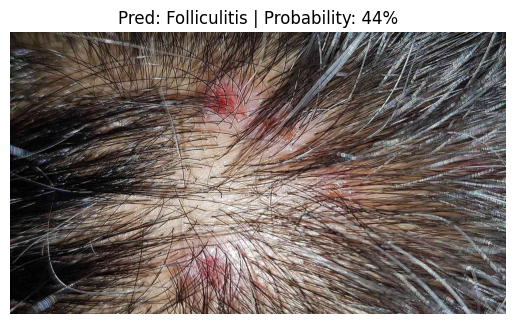

In [70]:
path = "/content/3.jpg"
Show_Predcitions(model=loaded_model.cpu(),
                 uploaded_image_path=path,
                 class_names=class_names,
                 image_size=(256,256),
                 )

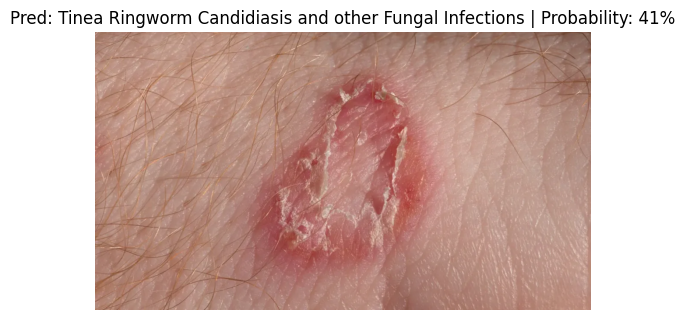

In [71]:
path = "/content/4.webp"
Show_Predcitions(model=loaded_model.cpu(),
                 uploaded_image_path=path,
                 class_names=class_names,
                 image_size=(256,256),
                 )

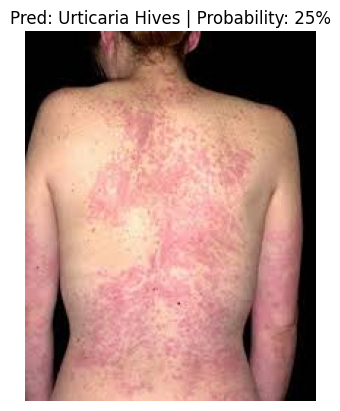

In [74]:
path = "/content/7.jpg"
Show_Predcitions(model=loaded_model.cpu(),
                 uploaded_image_path=path,
                 class_names=class_names,
                 image_size=(256,256),
                 )

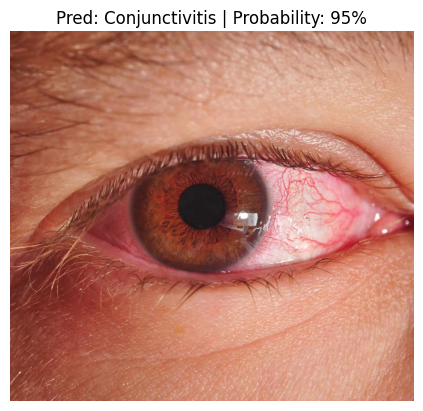

In [79]:
path = "/content/9.jpg"
Show_Predcitions(model=loaded_model.cpu(),
                 uploaded_image_path=path,
                 class_names=class_names,
                 image_size=(256,256),
                 )

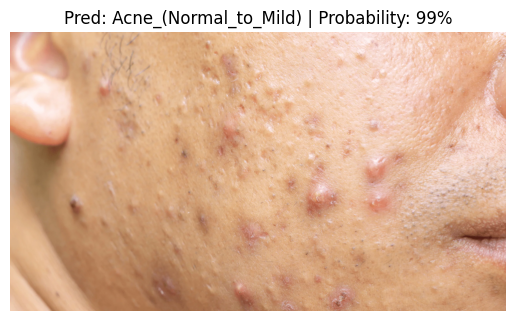

In [86]:
path = "/content/14.webp"
Show_Predcitions(model=loaded_model.cpu(),
                 uploaded_image_path=path,
                 class_names=class_names,
                 image_size=(256,256),
                 )